<a href="https://colab.research.google.com/github/ismailazdad/vision_detection_benchmark/blob/main/yolov7_white_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Sommaire
        </h1>
    </div>
</div>

- **[Preparation du dataset](#pre)**

- **[Verification des annotations](#ve)**

- **[Yolo v7 entrainement](#en)**

- **[Resultat](#re)**

- **[Test du modele](#te)**

https://github.com/WongKinYiu/yolov7



In [2]:
from google.colab import drive
drive.mount('/content/ShardDrives/', force_remount=True)

Mounted at /content/ShardDrives/


In [3]:
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image, ImageDraw

<a name='pre'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Preparation du datatset
        </h1>
    </div>
</div>

Repartition du dataset :

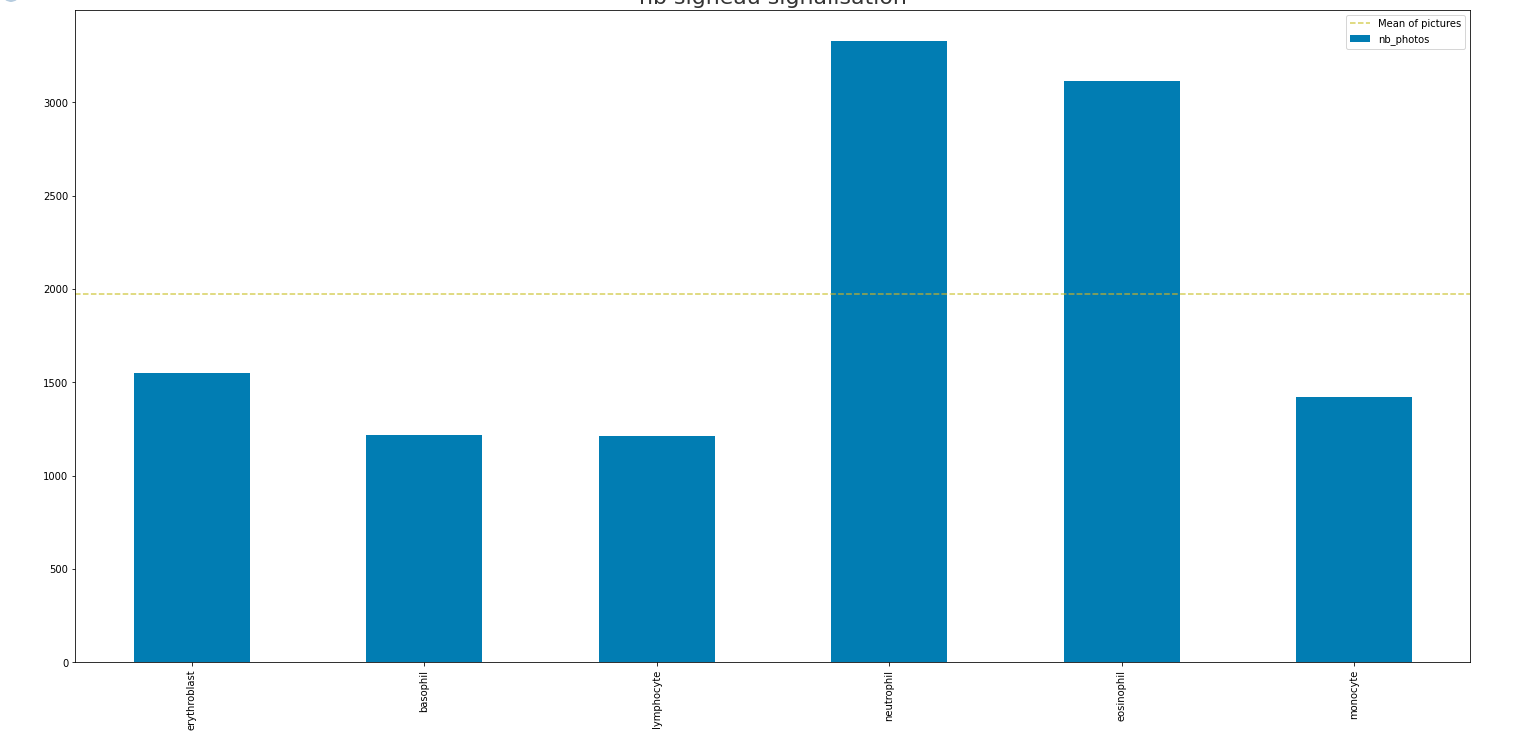

In [4]:
!rm -rf /content/bloods

In [ ]:
!unzip /content/ShardDrives/MyDrive/bloods/blood_dataset_yolo.zip -d /content/

In [ ]:
cd /content/

/content


In [6]:
!git clone https://github.com/WongKinYiu/yolov7

Cloning into 'yolov7'...
remote: Enumerating objects: 756, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 756 (delta 1), reused 5 (delta 1), pack-reused 749
Receiving objects: 100% (756/756), 67.48 MiB | 16.90 MiB/s, done.
Resolving deltas: 100% (376/376), done.


In [ ]:
%cd yolov7/
!pip install -r requirements.txt

In [8]:
!cp -avr /content/ShardDrives/MyDrive/bloods/blood.yaml /content/yolov7/data/blood.yaml

'/content/ShardDrives/MyDrive/bloods/blood.yaml' -> '/content/yolov7/data/blood.yaml'


In [9]:
cd /content/yolov7/

/content/yolov7


In [10]:
pwd

'/content/yolov7'

In [11]:
lymp_list = ['basophil','erythroblast','lymphocyte','neutrophil','eosinophil','monocyte']
class_name_to_id_mapping = {}
for i, elem in enumerate(lymp_list):
    class_name_to_id_mapping[elem] = i
print(class_name_to_id_mapping)

{'basophil': 0, 'erythroblast': 1, 'lymphocyte': 2, 'neutrophil': 3, 'eosinophil': 4, 'monocyte': 5}


In [ ]:
cd ..

/


In [ ]:
annotations = [os.path.join('/content/blood_dataset_yolo/labels/test', x) for x in os.listdir('/content/blood_dataset_yolo/labels/test') if x[-3:] == "txt"]
annotations

In [ ]:
# import glob
# for filename in glob.iglob('/content/blood_dataset_yolo/labels/**/*.txt', recursive=True):
#      print(filename)

In [13]:
from pathlib import Path
from os.path import isfile

len([x for x in Path('/content/blood_dataset_yolo/labels/').rglob('*') if isfile(x)])

11838

In [14]:
import os
path = '/content/blood_dataset_yolo/labels/'
mn = 20
folders = ([name for name in os.listdir(path)
            if os.path.isdir(os.path.join(path, name)) ]) # get all directories 
for folder in folders:
    contents = os.listdir(os.path.join(path,folder)) # get list of contents
    if len(contents) > mn: # if greater than the limit, print folder and number of contents
        print(folder,len(contents))

test 1185
train 9470
val 1183


In [15]:
import os
import sys
annotation_list = []
# directory = os.path.dirname(os.path.realpath(sys.argv[0])) #get the directory of your script
for subdir, dirs, files in os.walk('/content/blood_dataset_yolo/labels/'):
    for filename in files:
        subdirectoryPath = os.path.relpath(subdir, 'labels') #get the path to your subdirectory
        filePath = os.path.join(subdirectoryPath, filename) #get the path to your file
#         path = '/media/ismail/Elements/formation/projet7/standford_dogs_dataset_yolo/labels/'+ subdirectoryPath+'/'
        if(filename.find('.txt') > 0):
            annotation_list.append(filePath.replace('..',''))
print(len(annotation_list))

11838


In [16]:
annotation_list[0]

'//blood_dataset_yolo/labels/test/SNE_70096.txt'

<a name='ve'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Verification des annotations
        </h1>
    </div>
</div>

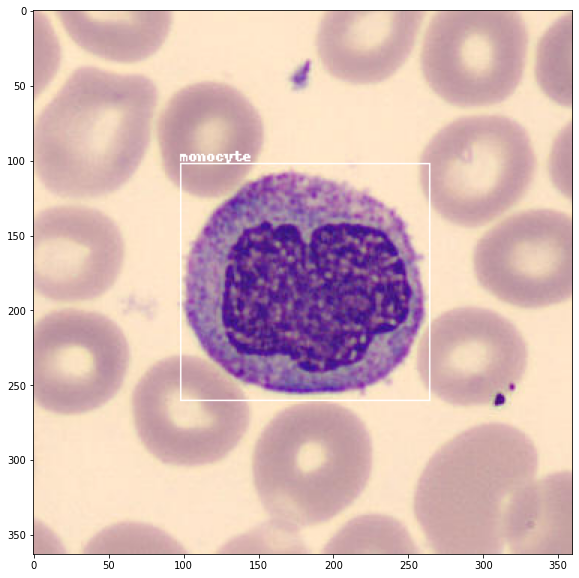

In [17]:
import random
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("labels", "images").replace("txt", "jpg")
# assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)
fig = plt.figure(figsize=(12,10))
#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

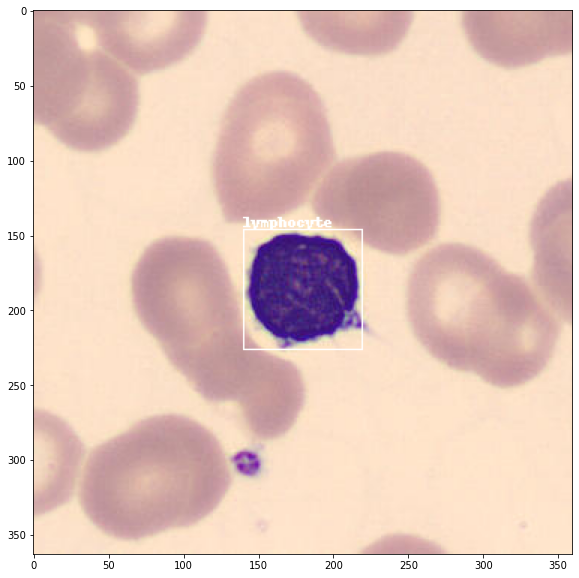

In [18]:
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("labels", "images").replace("txt", "jpg")
# assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)
fig = plt.figure(figsize=(12,10))
#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

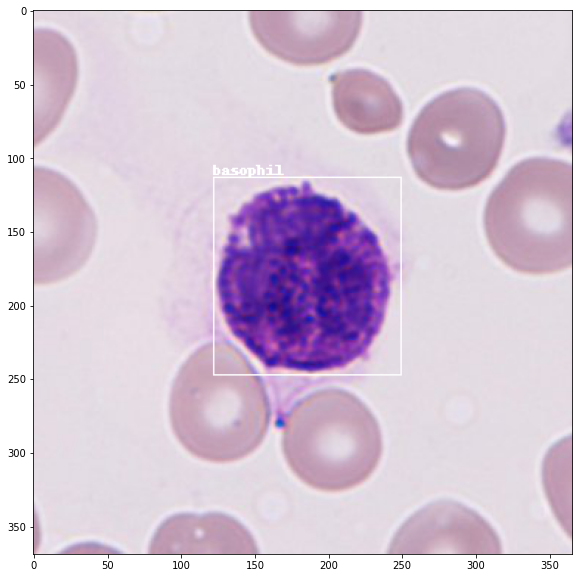

In [19]:
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("labels", "images").replace("txt", "jpg")
# assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)
fig = plt.figure(figsize=(12,10))
#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [20]:
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 13.3 MB/s 
     |████████████████████████████████| 181 kB 72.8 MB/s 
     |████████████████████████████████| 157 kB 71.5 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 157 kB 93.4 MB/s 
     |████████████████████████████████| 157 kB 96.0 MB/s 
     |████████████████████████████████| 157 kB 102.0 MB/s 
     |████████████████████████████████| 157 kB 86.3 MB/s 
     |████████████████████████████████| 156 kB 101.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=7557b9f3a24b7966ab023bb6c42953b16f60d651e2e1ae4b72a5689b6e4f7371
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.m

In [21]:
!wandb.init(project="yolov7_white_cell", entity="ismail-azdad")

/bin/bash: -c: line 0: syntax error near unexpected token `project="yolov7_white_cell",'
/bin/bash: -c: line 0: `wandb.init(project="yolov7_white_cell", entity="ismail-azdad")'


In [22]:
!pwd

/content/yolov7


<a name='en'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Yolo v7 entrainement
        </h1>
    </div>
</div>

j'ai tester le model yolov7 normal , il faudrait faire le test avec yolov7x, je pense qu il va donner de bien meilleur resultat (modele a telecharger dans le repo)

In [27]:
# !python train.py  --hyp hyp.scratch-med.yaml --img 360 --batch 16 --epochs 50 --data blood.yaml --weights yolov5l.pt --cfg yolov5l.yaml --project bloods --name blood --device 0 --cache

!python train.py --workers 16 --epochs 50  --entity 'yolov7' --device 0 --batch-size 32 --data data/blood.yaml --img 360 360 --cfg cfg/training/yolov7.yaml --weights '/content/ShardDrives/MyDrive/bloods/yolov7_training.pt' --name blood_yolov7 --hyp data/hyp.scratch.custom.yaml --cache-images



YOLOR 🚀 v0.1-107-g44d8ab4 torch 1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Namespace(adam=False, artifact_alias='latest', batch_size=32, bbox_interval=-1, bucket='', cache_images=True, cfg='cfg/training/yolov7.yaml', data='data/blood.yaml', device='0', entity='yolov7', epochs=50, evolve=False, exist_ok=False, freeze=[0], global_rank=-1, hyp='data/hyp.scratch.custom.yaml', image_weights=False, img_size=[360, 360], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='blood_yolov7', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/blood_yolov7', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=32, upload_dataset=False, weights='/content/ShardDrives/MyDrive/bloods/yolov7_training.pt', workers=16, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight

In [28]:
!mkdir /content/ShardDrives/MyDrive/bloods/blood_result_yolov7

In [29]:
!cp -fr /content/yolov7/runs/train/blood_yolov7 /content/ShardDrives/MyDrive/bloods/blood_result_yolov7

In [ ]:
!cd /content/yolov5/

In [ ]:
!python detect.py --source /content/blood_dataset_yolo/images/test/ --weights /content/yolov7/runs/train/blood_yolov7/weights/best.pt --conf 0.25 --name bloods


In [31]:
!cp -fr /content/yolov7/runs/detect/bloods /content/ShardDrives/MyDrive/bloods/blood_result_yolov7/

In [ ]:
# !cp -fr /content/YOLOv6/runs/val/blood_test2 /content/ShardDrives/MyDrive/bloods/blood_result_yolov6s/

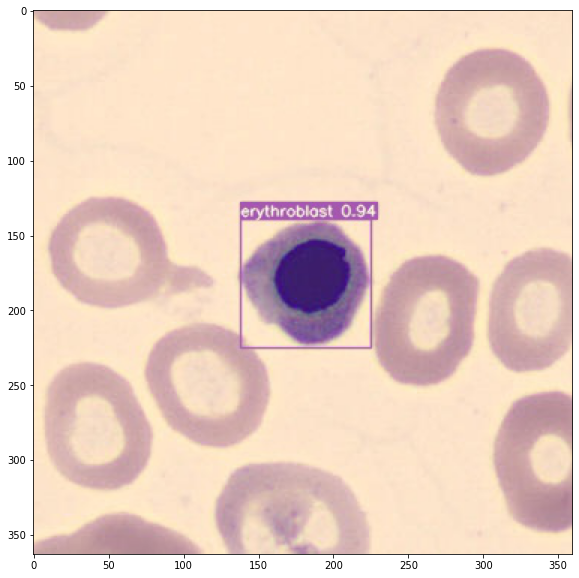

In [32]:
import os
from PIL import Image, ImageDraw
import random
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(12,10))
detections_dir = "/content/yolov7/runs/detect/bloods/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

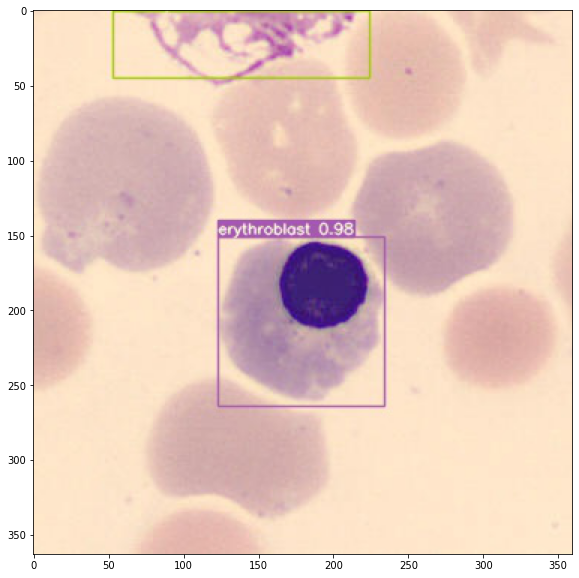

In [33]:
fig = plt.figure(figsize=(12,10))
random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

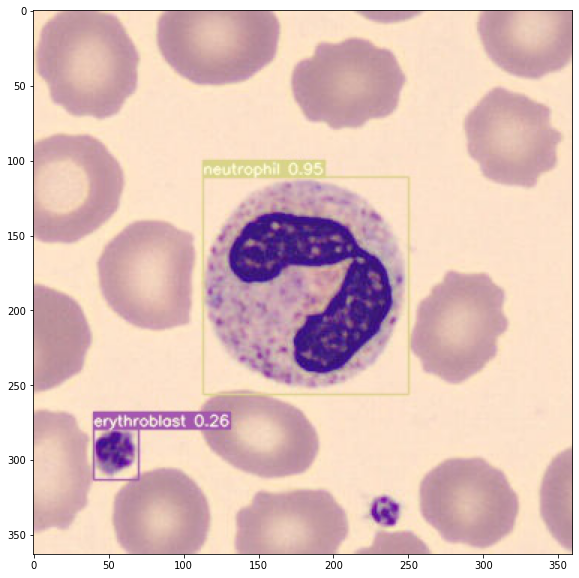

In [34]:
fig = plt.figure(figsize=(12,10))
random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

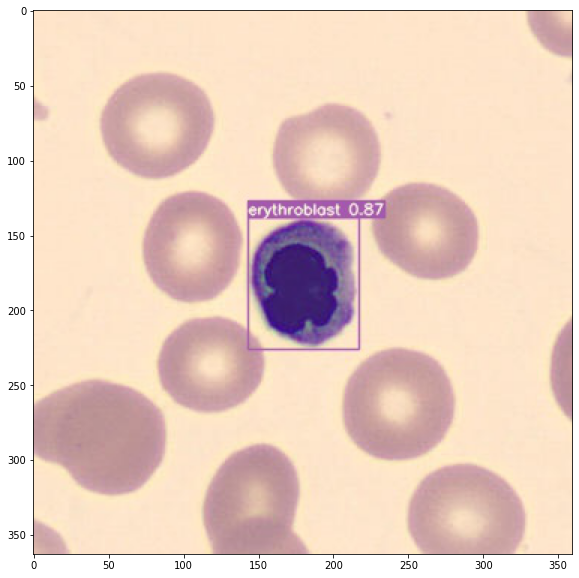

In [35]:
fig = plt.figure(figsize=(12,10))
random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [ ]:
!pwd

/content/YOLOv6


<a name='re'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Resultat
        </h1>
    </div>
</div>

In [42]:
# !python test.py --weights  /content/ShardDrives/MyDrive/bloods/blood_result_yolov7/blood_yolov7/weights/best.pt --data blood.yaml --task test --name blood_test --img-size 360  --verbose


!python test.py --data data/blood.yaml --img 384 --batch 32 --conf 0.001 --iou 0.65 --device 0 --weights /content/yolov7/runs/train/blood_yolov7/weights/best.pt --name yolov7_384_val


Namespace(augment=False, batch_size=32, conf_thres=0.001, data='data/blood.yaml', device='0', exist_ok=False, img_size=384, iou_thres=0.65, name='yolov7_640_val', no_trace=False, project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='val', verbose=False, weights=['/content/yolov7/runs/train/blood_yolov7/weights/best.pt'])
YOLOR 🚀 v0.1-107-g44d8ab4 torch 1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36508742 parameters, 6194944 gradients, 103.2 GFLOPS
 Convert model to Traced-mo

In [ ]:
# !python detect.py --source /content/standford_dogs_dataset/images/test/ --weights /content/ShardDrives/MyDrive/dogs/best.pt --conf 0.25 --name dogs --line-thickness 1

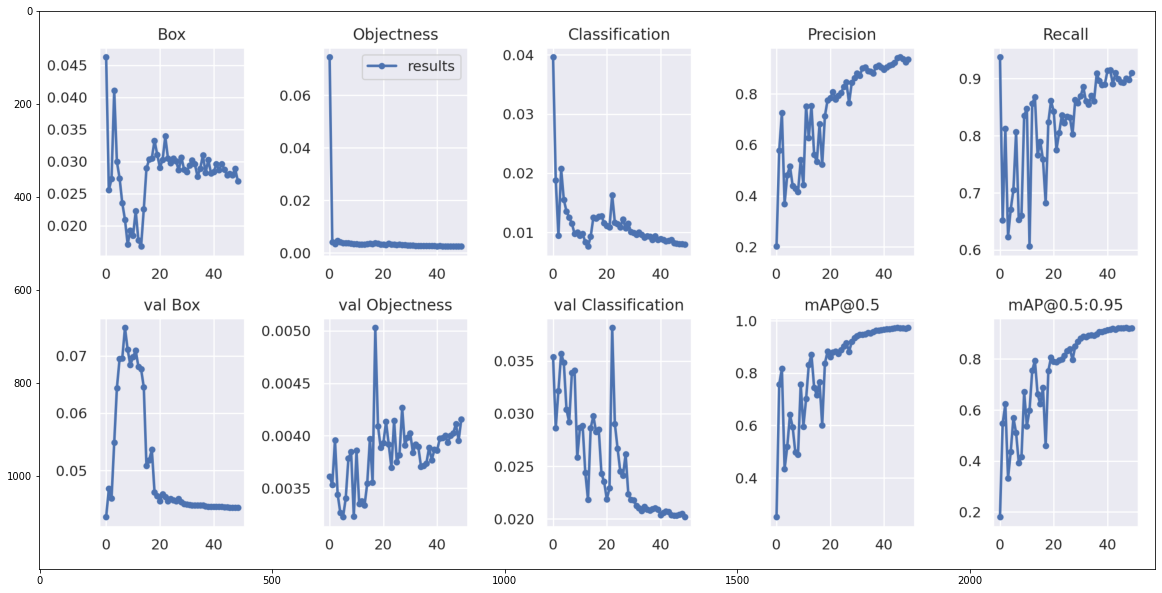

In [50]:
plt.figure(figsize=(20,20)) 
plt.imshow(np.array(Image.open("/content/yolov7/runs/train/blood_yolov7/results.png")))

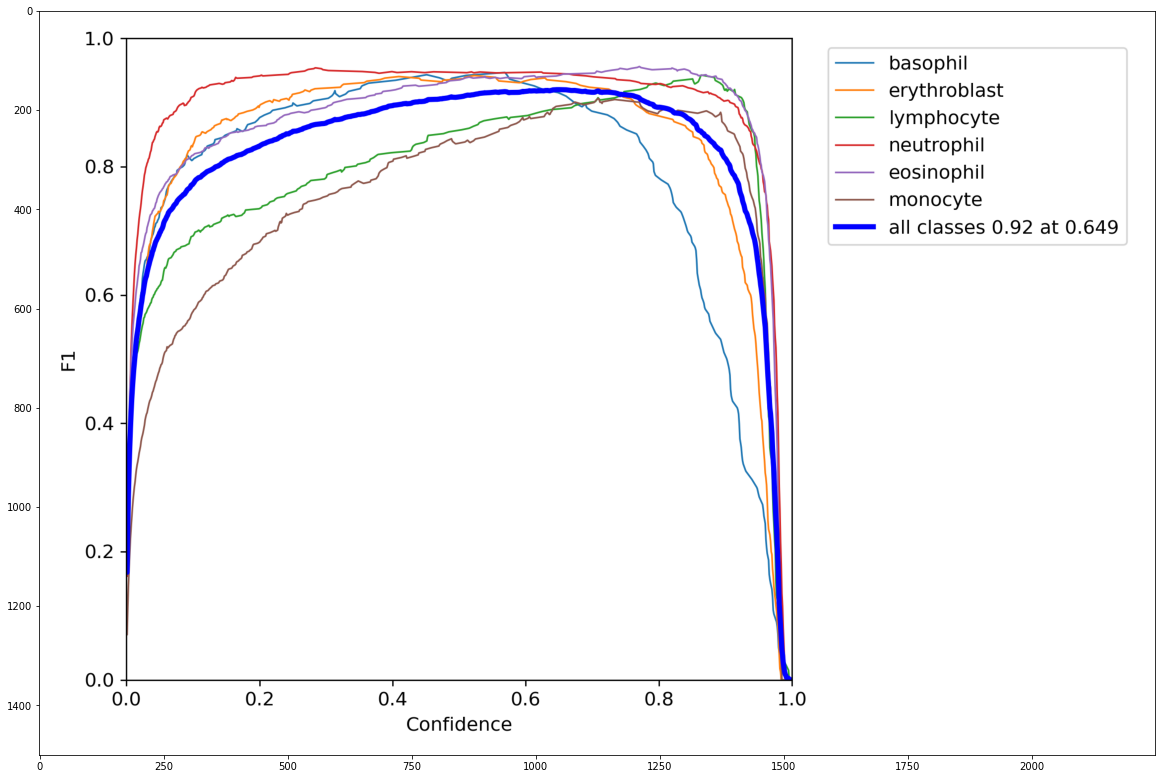

In [51]:
plt.figure(figsize=(20,20)) 
plt.imshow(np.array(Image.open("/content/yolov7/runs/train/blood_yolov7/F1_curve.png")))

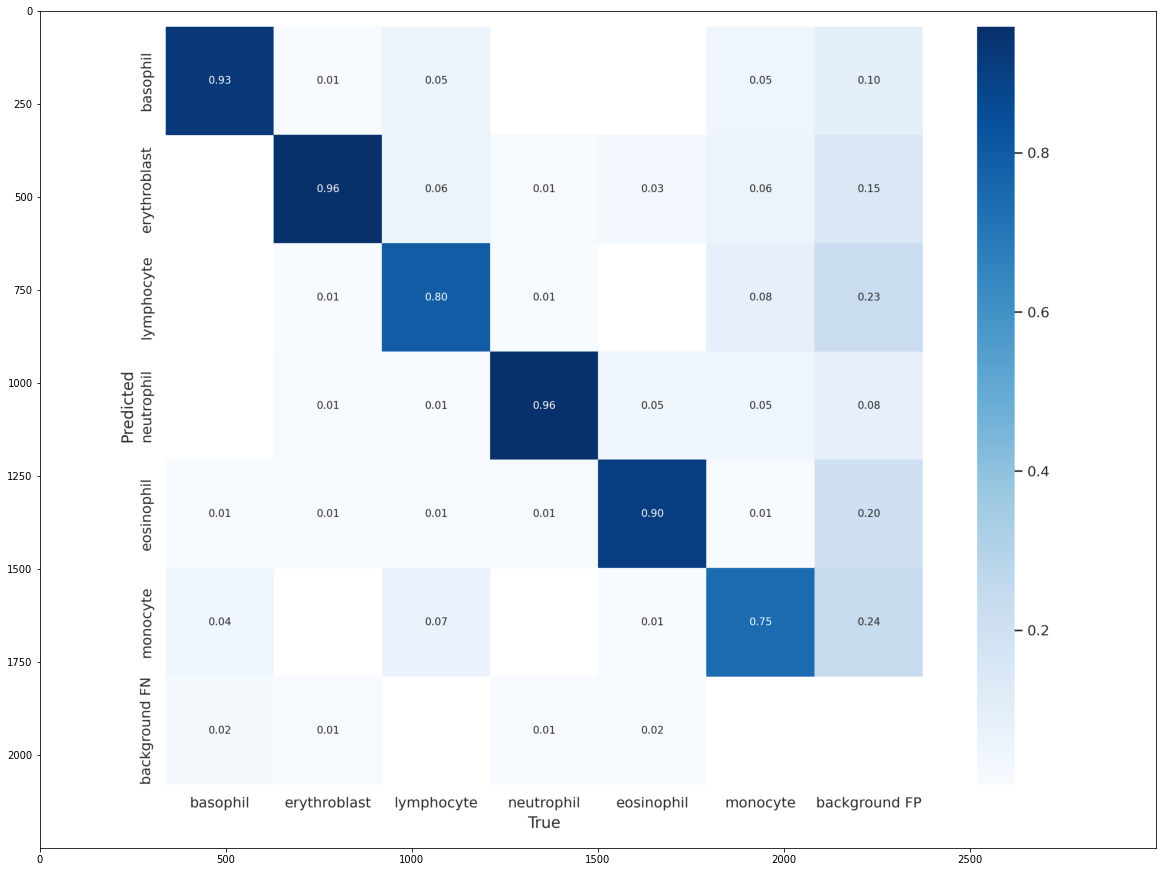

In [52]:
plt.figure(figsize=(20,20)) 
plt.imshow(np.array(Image.open("/content/yolov7/runs/train/blood_yolov7/confusion_matrix.png")))

In [66]:
import pandas as pd
results = pd.read_csv("/content/yolov7/runs/train/blood_yolov7/results.txt", delim_whitespace=True,header=None)
results

0      1        2         3         4        5   6    7       8   \
0    0/49  14.5G  0.04629  0.074550  0.039630  0.16050  50  384  0.2019   
1    1/49  14.5G  0.02556  0.004074  0.018840  0.04848  54  384  0.5783   
2    2/49  14.5G  0.02727  0.003429  0.009457  0.04016  62  384  0.7250   
3    3/49  14.5G  0.04108  0.004618  0.020760  0.06646  58  384  0.3691   
4    4/49  14.5G  0.02997  0.004041  0.015540  0.04955  54  384  0.4820   
5    5/49  14.5G  0.02741  0.003779  0.013550  0.04474  56  384  0.5164   
6    6/49  14.5G  0.02352  0.003725  0.012570  0.03981  60  384  0.4401   
7    7/49  14.5G  0.02096  0.003694  0.011500  0.03616  49  384  0.4284   
8    8/49  14.5G  0.01711  0.003500  0.009778  0.03039  57  384  0.4149   
9    9/49  14.5G  0.01929  0.003429  0.009980  0.03270  58  384  0.5412   
10  10/49  14.5G  0.01843  0.003325  0.009439  0.03120  60  384  0.4438   
11  11/49  14.5G  0.02230  0.003282  0.009745  0.03533  50  384  0.7517   
12  12/49  14.5G  0.01771  0.003241  0.008389  0.02934  64  384  0.6270   
13  13/49  14.5G  0.01678  0.003141  0.007641  0.02757  44  384  0.7531   
14  14/49  14.5G  0.02256  0.003343  0.009320  0.03523  57  384  0.5618   
15  15/49  14.5G  0.02894  0.003611  0.012530  0.04508  45  384  0.5339   
16  16/49  14.5G  0.03032  0.003444  0.012410  0.04618  52  384  0.6813   
17  17/49  14.5G  0.03053  0.003734  0.012700  0.04696  57  384  0.5226   
18  18/49  14.5G  0.03328  0.003628  0.012770  0.04967  50  384  0.7133   
19  19/49  14.5G  0.03109  0.003292  0.011560  0.04595  59  384  0.7753   
20  20/49  14.5G  0.02908  0.003202  0.011130  0.04342  53  384  0.7834   
21  21/49  14.5G  0.03025  0.003103  0.010920  0.04428  50  384  0.8077   
22  22/49  14.5G  0.03394  0.003569  0.016320  0.05383  57  384  0.7790   
23  23/49  14.5G  0.03046  0.003186  0.011650  0.04530  48  384  0.7929   
24  24/49  14.5G  0.02980  0.003308  0.011440  0.04455  77  384  0.8040   
25  25/49  14.5G  0.03046  0.003117  0.010860  0.04444  61  384  0.8270   
26  26/49  14.5G  0.03004  0.003260  0.012240  0.04554  56  384  0.8460   
27  27/49  14.5G  0.02868  0.003081  0.010700  0.04246  69  384  0.7632   
28  28/49  14.5G  0.03065  0.003136  0.011490  0.04527  55  384  0.8449   
29  29/49  14.5G  0.02877  0.002951  0.010090  0.04181  55  384  0.8616   
30  30/49  14.5G  0.02839  0.002914  0.009972  0.04127  66  384  0.8810   
31  31/49  14.5G  0.02942  0.002838  0.009629  0.04189  54  384  0.8717   
32  32/49  14.5G  0.03020  0.002760  0.009981  0.04294  60  384  0.9014   
33  33/49  14.5G  0.02962  0.002755  0.009609  0.04199  55  384  0.9042   
34  34/49  14.5G  0.02768  0.002756  0.009139  0.03958  49  384  0.8892   
35  35/49  14.5G  0.02891  0.002698  0.009374  0.04098  47  384  0.8883   
36  36/49  14.5G  0.03099  0.002697  0.009289  0.04298  61  384  0.8802   
37  37/49  14.5G  0.02822  0.002666  0.008787  0.03967  62  384  0.9056   
38  38/49  14.5G  0.03030  0.002689  0.009423  0.04242  69  384  0.9118   
39  39/49  14.5G  0.02818  0.002650  0.008799  0.03963  49  384  0.9046   
40  40/49  14.5G  0.02837  0.002591  0.008898  0.03986  67  384  0.8948   
41  41/49  14.5G  0.02959  0.002630  0.008753  0.04097  73  384  0.9043   
42  42/49  14.5G  0.02871  0.002592  0.008499  0.03980  57  384  0.9112   
43  43/49  14.5G  0.02964  0.002567  0.008635  0.04084  56  384  0.9148   
44  44/49  14.5G  0.02874  0.002579  0.008761  0.04008  63  384  0.9220   
45  45/49  14.5G  0.02787  0.002529  0.008183  0.03858  52  384  0.9406   
46  46/49  14.5G  0.02812  0.002534  0.008093  0.03875  77  384  0.9442   
47  47/49  14.5G  0.02792  0.002524  0.008082  0.03853  71  384  0.9364   
48  48/49  14.5G  0.02888  0.002529  0.008080  0.03949  58  384  0.9244   
49  49/49  14.5G  0.02696  0.002477  0.007972  0.03741  52  384  0.9343   

        9       10      11       12        13       14  
0   0.9378  0.2505  0.1799  0.04186  0.003612  0.03540  
1   0.6516  0.7568  0.5470  0.04680  0.003531  0.02865  
2   0.8124

**reporting disponible  link wandb :**

https://wandb.ai/ismail-azdad/YOLOR/reports/Yolov7-white-blood--VmlldzoyNTM3MDQy?accessToken=rhi2kkkgfgnriqjph3zvpigpun5wcfxk7uh3lmwdneetlfsdmrgwtgld8hw99ikm

<a name='te'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Test du modele
        </h1>
    </div>
</div>

In [43]:
def show_images_from_directory(path, num_sample):
    fig = plt.figure(figsize=(100,100))
    fig.patch.set_facecolor('#377AB7')
    images = os.listdir(path + "/" )[:num_sample]
    for i in range(num_sample):
        img = imgmp.imread(path+"/"+images[i])
        plt.subplot(num_sample/num_sample+1, num_sample, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show() 

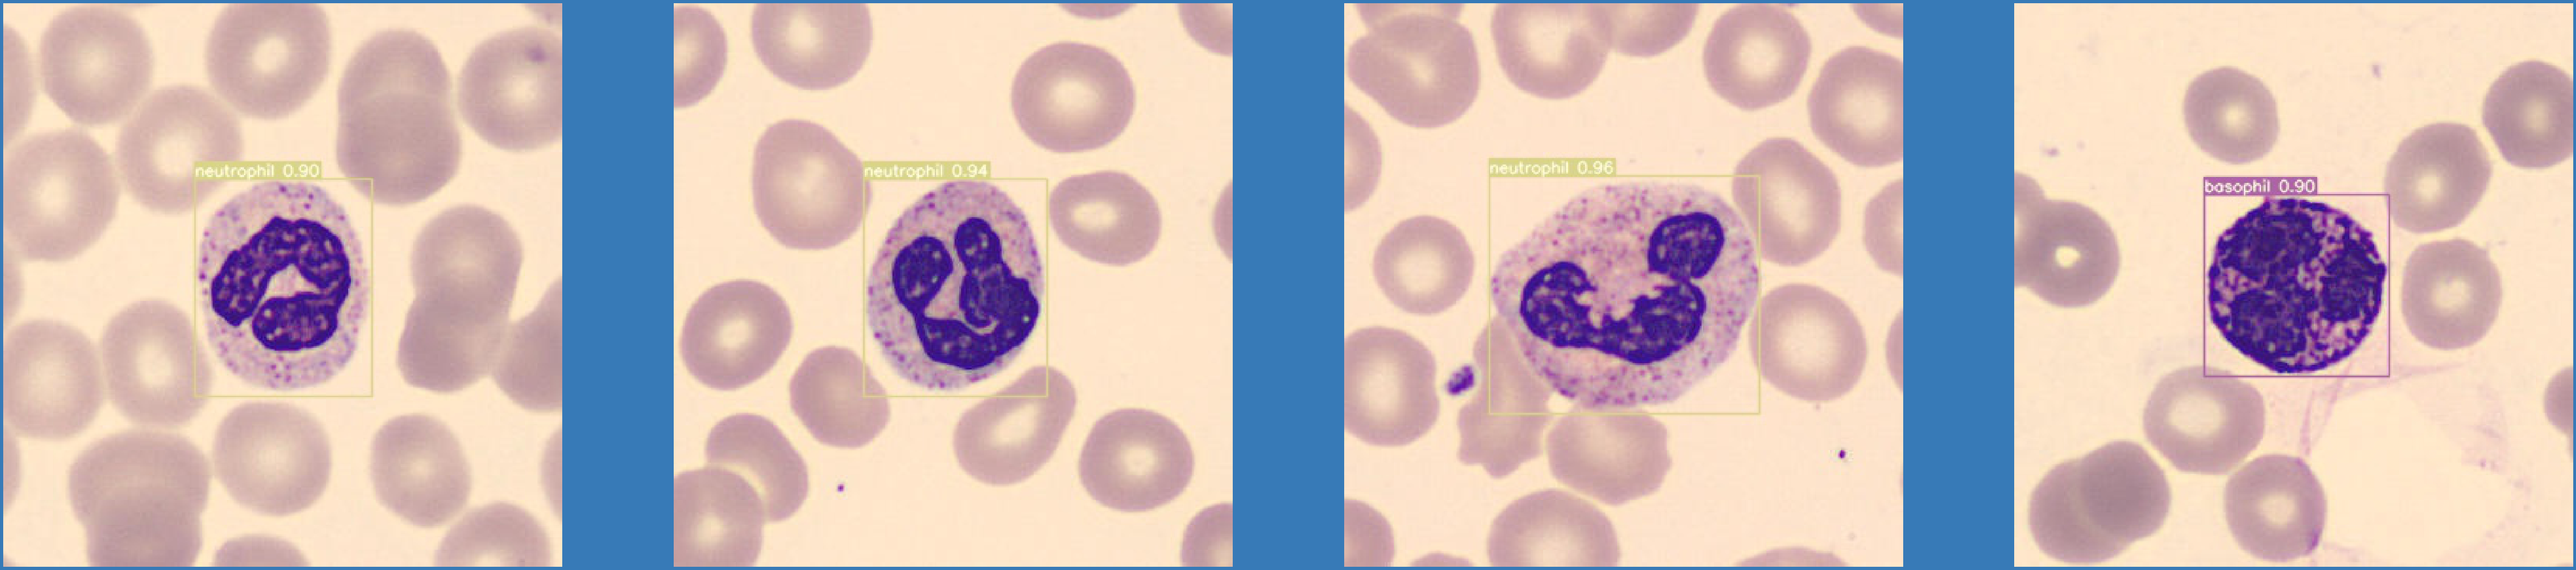

In [45]:
import matplotlib.image as imgmp
import os
show_images_from_directory("/content/yolov7/runs/detect/bloods", 4)

In [46]:
import os
from PIL import Image, ImageDraw
import random
import numpy as np
import matplotlib.pyplot as plt
detections_dir = "/content/yolov7/runs/detect/bloods"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

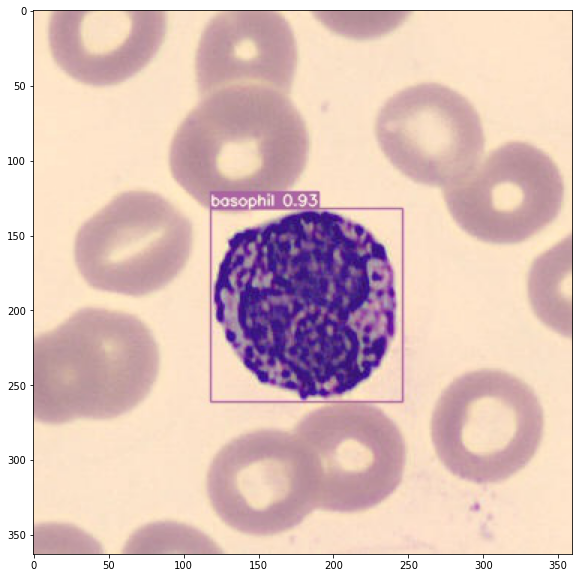

In [47]:
plt.figure(figsize=(10,10))
random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

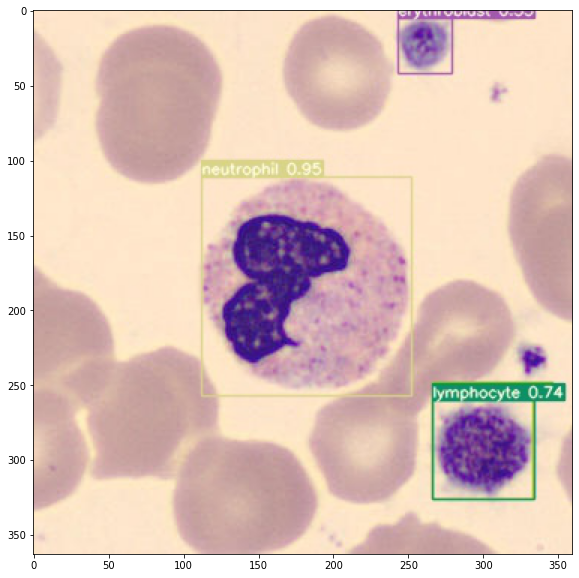

In [48]:
plt.figure(figsize=(10,10))
random.seed(10)
random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

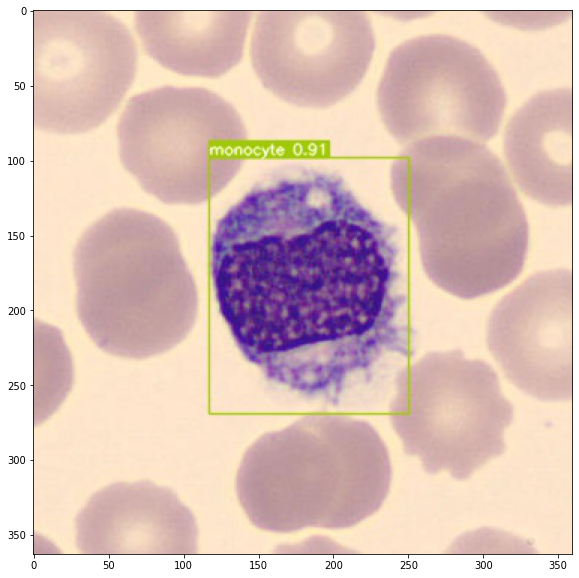

In [49]:
plt.figure(figsize=(10,10))
random.seed(520)
random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))